# Edge detection

There is a lot of methods to detect the edges of an image. Each have its own advantages and drawbacks. We tested several of them and will use the one that seems the most apporpiate to us for each category of image.

In [1]:
import cv2
import numpy as np
import tools
import matplotlib.cm as cm   
from ipywidgets import interact, fixed

from image import *
from edge import *
from line import *

from notebook_utils import *

## Edges

In [3]:
ui, out = build_ui_edges()
display(ui, out)

Output()

## Building edges

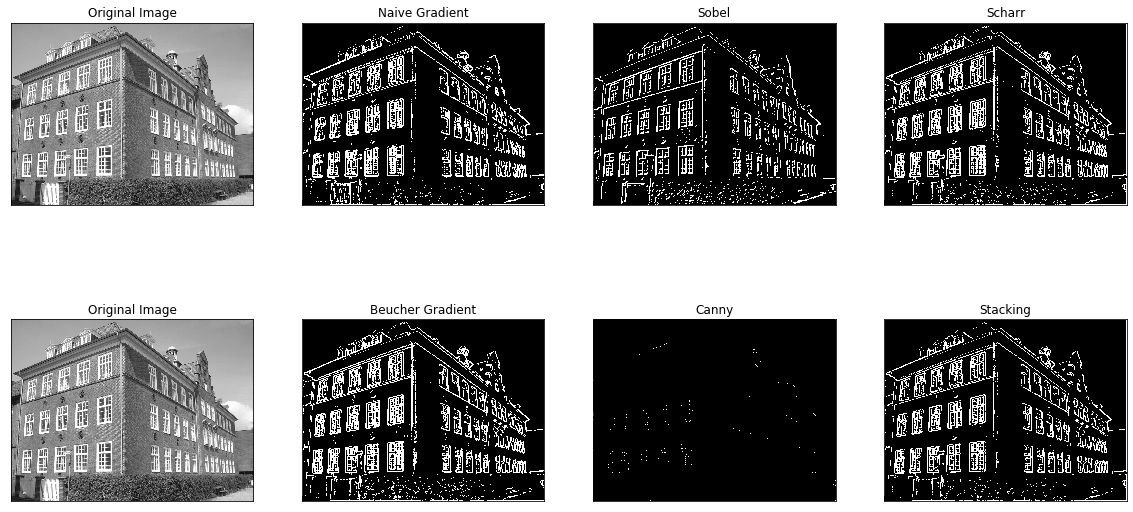

In [4]:
img = load_gray_img("img/building.png")

naive_grad = get_optimal_grads("building", "Naive Gradient")
sobel_grad = get_optimal_grads("building", "Sobel")
scharr_grad = get_optimal_grads("building", "Scharr")
canny_grad = get_optimal_grads("building", "Canny")
beucher_grad = get_optimal_grads("building", "Beucher")
stacking_grad = get_optimal_grads("building", "Stacking")

tools.multiPlot(2, 4, 
        (img, naive_grad, sobel_grad, scharr_grad, img, beucher_grad, canny_grad, stacking_grad),
        ('Original Image', 'Naive Gradient', 'Sobel', 'Scharr', 'Original Image', 'Beucher Gradient', 'Canny', 'Stacking'),
        cmap_tuple=(cm.gray, cm.gray, cm.gray, cm.gray, cm.gray, cm.gray, cm.gray, cm.gray))

## Sudoku edges

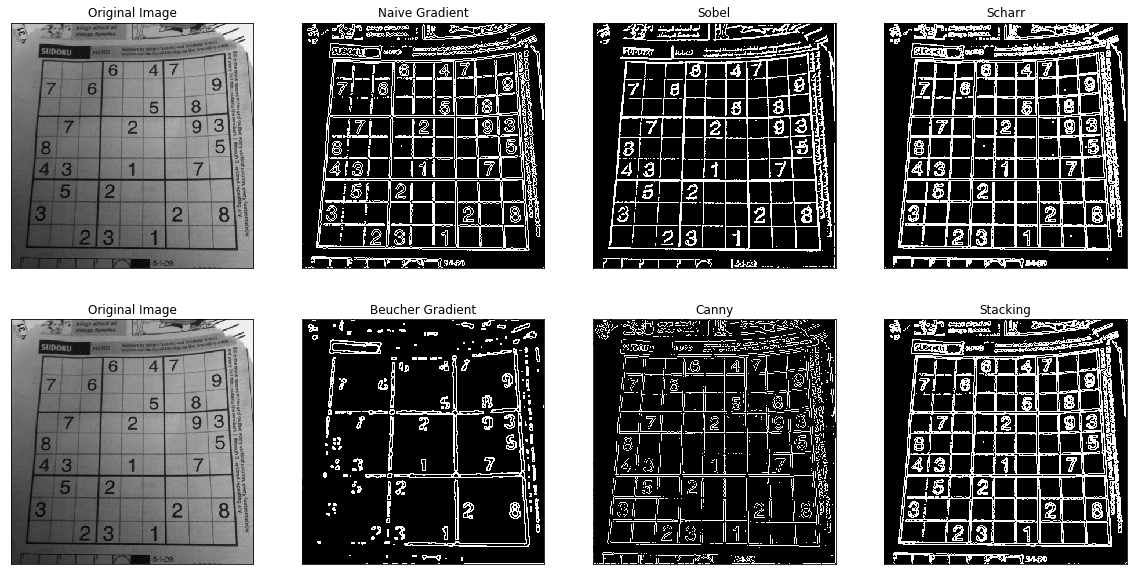

In [5]:
img = load_gray_img("img/sudoku.png")

naive_grad = get_optimal_grads("sudoku", "Naive Gradient")
sobel_grad = get_optimal_grads("sudoku", "Sobel")
scharr_grad = get_optimal_grads("sudoku", "Scharr")
canny_grad = get_optimal_grads("sudoku", "Canny")
beucher_grad = get_optimal_grads("sudoku", "Beucher")
stacking_grad = get_optimal_grads("sudoku", "Stacking")

tools.multiPlot(2, 4, 
        (img, naive_grad, sobel_grad, scharr_grad, img, beucher_grad, canny_grad, stacking_grad),
        ('Original Image', 'Naive Gradient', 'Sobel', 'Scharr', 'Original Image', 'Beucher Gradient', 'Canny', 'Stacking'),
        cmap_tuple=(cm.gray, cm.gray, cm.gray, cm.gray, cm.gray, cm.gray, cm.gray, cm.gray))